This tutorial used Fourier-Galerkin method to solve a linear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp
import numpy as np
from jax import Array
import equinox as eqx


In this example, we solve a linear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix. We use the Fourier-Galerkin method to solve the problem.

We import the necessary modules and set up the environment. The module `xpektra` contains the operators and solvers for the Fourier-Galerkin method. We import the `SpectralSpace`, `TensorOperator`, `make_field`, `RotatedDifference`, `Fourier`, `ForwardDifference`, `GalerkinProjection`, `conjugate_gradient_while`, and `newton_krylov_solver` modules to create the operators and solvers.


In [2]:
from xpektra import (
    SpectralSpace,
    make_field,
)
from xpektra.scheme import RotatedDifference
from xpektra.projection_operator import GalerkinProjection
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient_while,
    newton_krylov_solver,
)
from xpektra.transform import FFTTransform
from xpektra.spectral_operator import SpectralOperator


To simplify the execution of the code, we define a `ElasticityOperator` class that contains the Fourier-Galerkin operator, the spatial operators, the tensor operators, and the FFT and IFFT operators. The `__init__` method initializes the operator and the `__call__` method computes the stresses in the real space given as 

$$
\mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}) \right) = \mathbf{0}
$$

We define the grid size and the length of the RVE and construct the structure of the RVE.

In [3]:
N = 199
ndim = 2
length = 1



# Create phase indicator (cylinder)
x = np.linspace(-0.5, 0.5, N)

if ndim == 3:
    Y, X, Z = np.meshgrid(x, x, x, indexing="ij")  # (N, N, N) grid
    phase = jnp.where(X**2 + Z**2 <= (0.2 / np.pi), 1.0, 0.0)  # 20% vol frac
else:
    X, Y = np.meshgrid(x, x, indexing="ij")  # (N, N) grid
    phase = jnp.where(X**2 + Y**2 <= (0.2 / np.pi), 1.0, 0.0)

## Definin the tensor operator and the spectral space

In [4]:
# tensor = TensorOperator(dim=ndim)
# space = SpectralSpace(size=N, dim=ndim, length=length)

fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=phase.shape, transform=fft_transform
)
rotated_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=rotated_scheme,
    space=space,
)

Next, we define the material parameters.

In [5]:
# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 10.0, 1000.0
mu1, mu2 = 0.25, 2.5
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase


The linear elasticity strain energy is given as 

$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [7]:
dofs_shape = make_field(dim=ndim, shape=phase.shape, rank=2).shape


@eqx.filter_jit
def strain_energy(eps_flat: Array) -> Array:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + op.trans(eps))
    energy = 0.5 * jnp.multiply(lambdas, op.trace(eps_sym) ** 2) + jnp.multiply(
        mu, op.trace(op.dot(eps_sym, eps_sym))
    )
    return energy.sum()

compute_stress = jax.jacrev(strain_energy)


In [8]:
Ghat = GalerkinProjection(scheme=rotated_scheme)


In [9]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps_flat = eps_flat.reshape(-1)
        sigma = compute_stress(eps_flat)
        residual_field = op.inverse(
            Ghat.project(op.forward(sigma.reshape(self.dofs_shape)))
        )
        return jnp.real(residual_field).reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps_flat = deps_flat.reshape(-1)
        dsigma = compute_stress(deps_flat)
        jvp_field = op.inverse(
            Ghat.project(op.forward(dsigma.reshape(self.dofs_shape)))
        )
        return jnp.real(jvp_field).reshape(-1)

In [12]:
applied_strains = jnp.diff(jnp.linspace(0, 1e-2, num=5))

deps = make_field(dim=2, shape=phase.shape, rank=2)
eps = make_field(dim=2, shape=phase.shape, rank=2)

residual_fn = Residual(Ghat=Ghat, dofs_shape=eps.shape)
jacobian_fn = Jacobian(Ghat=Ghat, dofs_shape=eps.shape)


In [13]:

for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps[:, :, 0, 0] = deps_avg
    deps[:, :, 1, 1] = deps_avg

    b = -residual_fn(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

eps = final_state[2].reshape(dofs_shape)
sig = compute_stress(final_state[2]).reshape(dofs_shape)


CG error = 154427.53350682425662
CG error = 0.00000016927254
CG error = 0.00000000016168
CG error = 0.00000000000001
Converged, Residual value : 8.676287155424726e-09
CG error = 154427.53350682425662
CG error = 0.00000016927224
CG error = 0.00000000016165
CG error = 0.00000000000001
Converged, Residual value : 8.978154378674178e-09
CG error = 154427.53350682419841
CG error = 0.00000016926903
CG error = 0.00000000016164
CG error = 0.00000000000001
Converged, Residual value : 9.032027559478541e-09
CG error = 154427.53350682428572
CG error = 0.00000016934745
CG error = 0.00000000016109
CG error = 0.00000000000001
Converged, Residual value : 9.466761234191381e-09


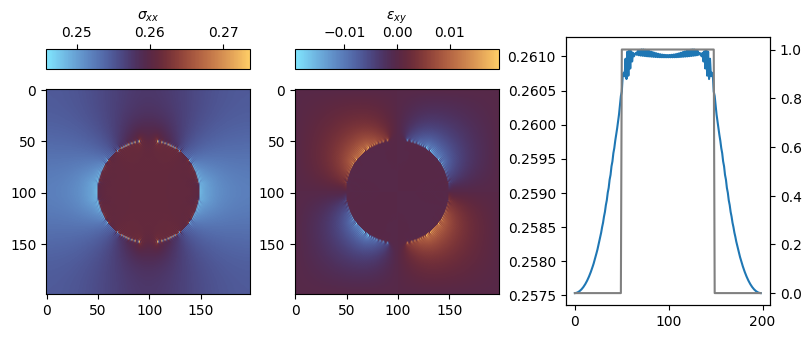

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3), layout="constrained")
cb1 = ax1.imshow(sig.at[:, :, 0, 0].get(), cmap="managua_r")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cb1, cax=cax, label=r"$\sigma_{xx}$", orientation="horizontal", location="top")

cb2 = ax2.imshow(eps.at[:, :, 0, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cb2, cax=cax, label=r"$\varepsilon_{xy}$", orientation="horizontal", location="top")

ax3.plot(sig.at[:, :, 0, 0].get()[:, int(N / 2)])
ax_twin = ax3.twinx()
ax_twin.plot(phase[int(N / 2), :], color="gray")
plt.show()
